<a href="https://colab.research.google.com/github/salmacmpeg/Assignment1_PR/blob/master/Movies_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
!pip install -q transformers  diffusers   pandas

In [128]:
!pip install -U datasets huggingface_hub fsspec

In [129]:
import torch
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline
import pandas as pd
from datasets import load_dataset

In [130]:
#credintials
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [131]:
#loading the movies data
dataset = load_dataset('bloc4488/TMDB-all-movies')
pandas_data = pd.DataFrame(dataset['train'])
pd.set_option('display.max_colwidth', 100)

Repo card metadata block was not found. Setting CardData to empty.


In [132]:
''' Exploration code

pandas_data.columns

#non beneficial -> to be removed
pandas_data['tagline'].isnull().sum() #contains null , i dont think will be beneficial in our motive
pandas_data['genres'] #needs splitting on comma and changing into list
print(pandas_data['production_companies'].isna().sum()) #contains some na values
print(pandas_data['production_countries'].isna().sum()) #i dont need that i think
pandas_data['spoken_languages'].unique()[:10] #i dont need that i think
pandas_data['producers'][:2]# i dont think this is beneficial
pandas_data['music_composer'].isna().sum()# i dont think this is beneficial

#beneficial -> needs processing
pandas_data['cast'][:2] #beneficial and needs processing
pandas_data['director'].isna().sum() #beneficial and needs processing
pandas_data['director_of_photography'].isna().sum() #beneficial and needs processing
pandas_data['writers'].isna().sum()#beneficial and needs processing
pandas_data['status'].unique()#beneficial and needs processing
pandas_data['release_date'].head(2)#beneficial and needs processing


columnsdrop = ['Unnamed: 0', 'revenue', 'runtime', 'vote_count',
                  'budget', 'imdb_id', 'original_language',
                  'tagline', 'production_countries', 'spoken_languages',
                  'producers','music_composer', 'director_of_photography', 'status']
beneficial_data=pandas_data.drop(columnsdrop, axis=1)

beneficial_data.columns

#helping plots
from matplotlib import pyplot as plt
pandas_data.plot(kind='scatter', x='vote_average', y='vote_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
beneficial_data['popularity'].plot(kind='hist', bins=20, title='popularity', xlim=(0, 150))
plt.gca().spines[['top', 'right',]].set_visible(False)

'''

" Exploration code\n\npandas_data.columns\n\n#non beneficial -> to be removed\npandas_data['tagline'].isnull().sum() #contains null , i dont think will be beneficial in our motive\npandas_data['genres'] #needs splitting on comma and changing into list\nprint(pandas_data['production_companies'].isna().sum()) #contains some na values\nprint(pandas_data['production_countries'].isna().sum()) #i dont need that i think\npandas_data['spoken_languages'].unique()[:10] #i dont need that i think\npandas_data['producers'][:2]# i dont think this is beneficial\npandas_data['music_composer'].isna().sum()# i dont think this is beneficial\n\n#beneficial -> needs processing\npandas_data['cast'][:2] #beneficial and needs processing\npandas_data['director'].isna().sum() #beneficial and needs processing\npandas_data['director_of_photography'].isna().sum() #beneficial and needs processing\npandas_data['writers'].isna().sum()#beneficial and needs processing\npandas_data['status'].unique()#beneficial and need

In [191]:
def preprocess(df_movie_orig: pd.DataFrame, verbose:bool = False) -> pd.DataFrame:

    droped_columns = ['Unnamed: 0', 'id', 'revenue', 'runtime', 'vote_count',
                  'budget', 'imdb_id', 'original_language', 'original_title',
                  'tagline', 'production_countries', 'spoken_languages',
                  'producers','music_composer', 'director_of_photography', 'status']
    if verbose: print(f'Dropping columns: {droped_columns}')

    beneficial_data=df_movie_orig.drop(droped_columns, axis=1)
    if verbose: print(f'Columns left: {beneficial_data.columns}, and shape is {beneficial_data.shape}')

    beneficial_data.dropna(inplace=True)
    if verbose: print(f'Dropping nan rows .... , and shape is {beneficial_data.shape}')

    beneficial_data = beneficial_data[beneficial_data['vote_average'] != 0.0]
    if verbose: print(f'Dropping rows  that has zero voting values .... , and shape is {beneficial_data.shape}')

    beneficial_data['release_date'] = beneficial_data['release_date'].apply(lambda x: x.strip().split('-')[0])# i will keep the year only
    beneficial_data['release_date'] = beneficial_data['release_date'].astype(int) #converting the release year to int
    if verbose: print('keeping only the year in the realse date, save it as int .....')

    beneficial_data['popularity'] = beneficial_data['popularity'].round().astype(int) #convert popularity to nearest integer
    if verbose: print('converting popularity float values to the nearest integers .....')

    beneficial_data['production_companies'] = beneficial_data['production_companies'].apply(lambda x: x.split(',')[0])  #take only the first company
    beneficial_data['production_companies'] = beneficial_data['production_companies'].apply(lambda x: x.replace(' ', ''))#join the text
    if verbose: print('Taking only the first production_company and remove the spaces in the name .....')

    beneficial_data['cast'] = beneficial_data['cast'].apply(lambda x: x.split(',')[0:3]) #take the first three comma separated names in the cast only
    beneficial_data['cast'] = beneficial_data['cast'].apply(lambda x: [y.replace(' ', '') for y in x] )#string join each entity in the cast list
    beneficial_data['cast'] = beneficial_data['cast'].apply(lambda x: ','.join(x)) #convert the list in each entity to a comma separated string
    if verbose: print('Taking only the first three cast members and remove the spaces in the name .....')

    beneficial_data['director'] = beneficial_data['director'].apply(lambda x: x.split(',')[0])
    beneficial_data['director'] = beneficial_data['director'].apply(lambda x: x.replace(' ', ''))
    if verbose: print('Taking only the first director and remove the spaces in the name .....')

    beneficial_data['writers'] = beneficial_data['writers'].apply(lambda x: x.split(',')[0])
    beneficial_data['writers'] = beneficial_data['writers'].apply(lambda x: x.replace(' ', ''))
    if verbose: print('Taking only the first writer and remove the spaces in the name .....')

    #reset the index for the beneficial dataframe
    beneficial_data.reset_index(drop=True, inplace=True)

    return beneficial_data



In [229]:
clean_data = preprocess(pandas_data, verbose=True)


Dropping columns: ['Unnamed: 0', 'id', 'revenue', 'runtime', 'vote_count', 'budget', 'imdb_id', 'original_language', 'original_title', 'tagline', 'production_countries', 'spoken_languages', 'producers', 'music_composer', 'director_of_photography', 'status']
Columns left: Index(['title', 'vote_average', 'release_date', 'overview', 'popularity',
       'genres', 'production_companies', 'cast', 'director', 'writers'],
      dtype='object'), and shape is (10000, 10)
Dropping nan rows .... , and shape is (8391, 10)
Dropping rows  that has zero voting values .... , and shape is (8322, 10)
keeping only the year in the realse date, save it as int .....
converting popularity float values to the nearest integers .....
Taking only the first production_company and remove the spaces in the name .....
Taking only the first three cast members and remove the spaces in the name .....
Taking only the first director and remove the spaces in the name .....
Taking only the first writer and remove the space

In [230]:
clean_data.head(2)

,title,vote_average,release_date,overview,popularity,genres,production_companies,cast,director,writers
0,Ariel,7.082,1988,"After the coal mine he works at closes and his father commits suicide, a Finnish man leaves for ...",10,"Drama, Comedy, Romance, Crime",VillealfaFilmproductions,"MarkkuRantala,EskoNikkari,MattiPellonpää",AkiKaurismäki,AkiKaurismäki
1,Shadows in Paradise,7.302,1986,"Nikander, a rubbish collector and would-be entrepreneur, finds his plans for success dashed when...",13,"Drama, Comedy, Romance",VillealfaFilmproductions,"EskoNikkari,MattiPellonpää,SirkkaSilin",AkiKaurismäki,AkiKaurismäki


In [231]:
final_data= clean_data.drop(['production_companies','cast','director','writers'],axis=1)

In [194]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), min_df=0.05)
tdm = cv.fit_transform(final_data['overview'])
vector_word_df_overview = pd.DataFrame(tdm.toarray(), columns=cv.get_feature_names_out())
print(vector_word_df_overview.shape)
vector_word_df_overview.head()

(8322, 19)


,family,father,finds,help,life,lives,love,man,new,old,story,time,war,way,wife,woman,world,years,young
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [195]:
cv2 = CountVectorizer(stop_words='english', ngram_range=(1,1))
tdm2 = cv2.fit_transform(final_data['genres'])
vector_word_df_generes = pd.DataFrame(tdm2.toarray(), columns=cv2.get_feature_names_out())
print(vector_word_df_generes.shape)
vector_word_df_generes.head()

(8322, 21)


,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
0,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [198]:
sub_df= final_data[['vote_average', 'release_date', 'popularity']]

In [199]:
features_db= pd.concat([vector_word_df_generes,vector_word_df_overview], axis=1)
features_db2= pd.concat([features_db,sub_df], axis=1)

Silhouette Score: 0.307
Davies-Bouldin Index: 1.019


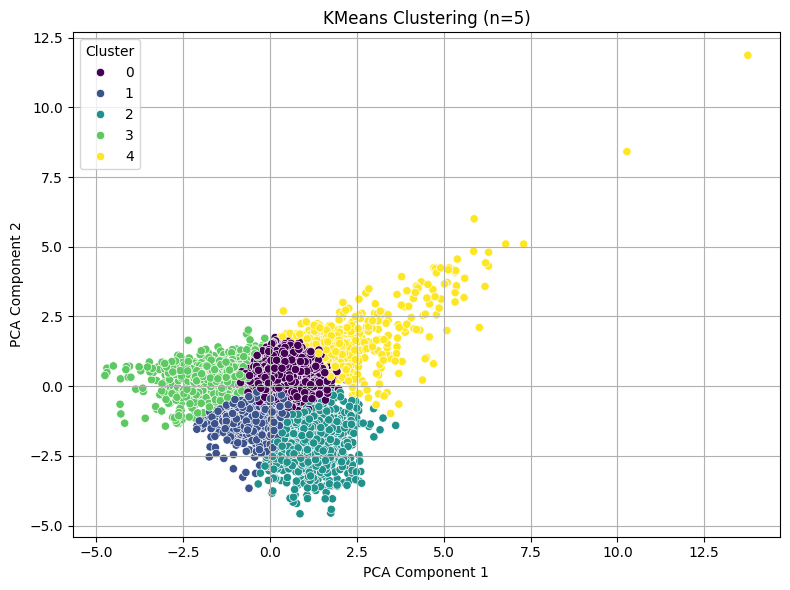

In [222]:
# 📦 Imports
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Assume you already have your DataFrame `pd_data`
# Replace this with your actual data loading logic if needed
# pd_data = pd.read_csv('your_data.csv')  # Example placeholder

# 📐 Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df)

# 🔍 Choose number of clusters
n_clusters = 5  # You can tune this based on domain knowledge or elbow method

# 🚀 Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

# 📊 Evaluation Metrics
sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")

# 🖼️ Visualization with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='viridis')
plt.title(f"KMeans Clustering (n={n_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [233]:

# 📦 Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 🎯 Assume you have your DataFrame loaded as `pd_data`
# pd_data = pd.read_csv('your_data.csv')  # Example loading

# ⚙️ Preprocessing: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df)

# 🔍 Fit NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(X_scaled)

# 📌 Find nearest neighbors (returns indices and distances)
distances, indices = nn_model.kneighbors(X_scaled)

row_index = 1

# 📝 View example result for first row
print("Nearest neighbors (indices) for row {row_index}:", indices[row_index])
print("Distances to neighbors:", distances[row_index])


# 🧾 Example: Print rows of neighbors for row 0

neighbor_indices = indices[row_index]
neighbor_rows = final_data.iloc[neighbor_indices]

print(f"Original row at index {row_index}:")
print(final_data.iloc[row_index], end="\n\n")

print(f"5 nearest neighbors for row {row_index}:")
print(neighbor_rows)


Nearest neighbors (indices) for row {row_index}: [   1 6581 3244  941 3445]
Distances to neighbors: [0.         0.08146749 0.134508   0.13603301 0.15644896]
Original row at index 1:
title                                                                                           Shadows in Paradise
vote_average                                                                                                  7.302
release_date                                                                                                   1986
overview        Nikander, a rubbish collector and would-be entrepreneur, finds his plans for success dashed when...
popularity                                                                                                       13
genres                                                                                       Drama, Comedy, Romance
Name: 1, dtype: object

5 nearest neighbors for row 1:
                                  title  vote_average  release_date

In [235]:

# 📦 Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 🎯 Assume you have your DataFrame loaded as `pd_data`
# pd_data = pd.read_csv('your_data.csv')  # Example loading

# ⚙️ Preprocessing: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_db)

# 🔍 Fit NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(X_scaled)

# 📌 Find nearest neighbors (returns indices and distances)
distances, indices = nn_model.kneighbors(X_scaled)

row_index = 1

# 📝 View example result for first row
print("Nearest neighbors (indices) for row {row_index}:", indices[row_index])
print("Distances to neighbors:", distances[row_index])


# 🧾 Example: Print rows of neighbors for row 0

neighbor_indices = indices[row_index]
neighbor_rows = final_data.iloc[neighbor_indices]

print(f"Original row at index {row_index}:")
print(final_data.iloc[row_index], end="\n\n")

print(f"5 nearest neighbors for row {row_index}:")
print(neighbor_rows)


Nearest neighbors (indices) for row {row_index}: [   1 7387 4057 1439 2209]
Distances to neighbors: [1.46000966e-07 1.46000966e-07 1.46000966e-07 1.46000966e-07
 1.46000966e-07]
Original row at index 1:
title                                                                                           Shadows in Paradise
vote_average                                                                                                  7.302
release_date                                                                                                   1986
overview        Nikander, a rubbish collector and would-be entrepreneur, finds his plans for success dashed when...
popularity                                                                                                       13
genres                                                                                       Drama, Comedy, Romance
Name: 1, dtype: object

5 nearest neighbors for row 1:
                               title  vote_ave

In [234]:

# 📦 Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 🎯 Assume you have your DataFrame loaded as `pd_data`
# pd_data = pd.read_csv('your_data.csv')  # Example loading

# ⚙️ Preprocessing: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_db2)

# 🔍 Fit NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(X_scaled)

# 📌 Find nearest neighbors (returns indices and distances)
distances, indices = nn_model.kneighbors(X_scaled)

row_index = 1

# 📝 View example result for first row
print("Nearest neighbors (indices) for row {row_index}:", indices[row_index])
print("Distances to neighbors:", distances[row_index])


# 🧾 Example: Print rows of neighbors for row 0

neighbor_indices = indices[row_index]
neighbor_rows = final_data.iloc[neighbor_indices]

print(f"Original row at index {row_index}:")
print(final_data.iloc[row_index], end="\n\n")

print(f"5 nearest neighbors for row {row_index}:")
print(neighbor_rows)


Nearest neighbors (indices) for row {row_index}: [   1 1439 8244 4057 7387]
Distances to neighbors: [1.46000966e-07 8.77728585e-01 1.51855776e+00 1.71119069e+00
 1.88942916e+00]
Original row at index 1:
title                                                                                           Shadows in Paradise
vote_average                                                                                                  7.302
release_date                                                                                                   1986
overview        Nikander, a rubbish collector and would-be entrepreneur, finds his plans for success dashed when...
popularity                                                                                                       13
genres                                                                                       Drama, Comedy, Romance
Name: 1, dtype: object

5 nearest neighbors for row 1:
                    title  vote_average  relea

In [ ]:

feature_extractor = pipeline("feature-extraction",
                             model="sentence-transformers/all-MiniLM-L6-v2",
                             device='mps')

# extract the embeddings
embeddings = books['Description'].apply(lambda x: feature_extractor(x)[0][0])
embeddings_books = np.vstack(embeddings)
embeddings_books.shape

# create a function to get book recommendations
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_books(embeddings, book_index, book_details, top_n=3):

    # specify the book
    b_embedding = np.array(embeddings[book_index]).reshape(1, -1)

    # calculate cosine similarity scores
    similarity_scores = cosine_similarity(b_embedding, embeddings)
    similarity_scores_series = pd.Series(similarity_scores.flatten(), name='similarity_score')

    # combine with book info and their similarity scores
    similarity_df = pd.concat([book_details, similarity_scores_series], axis=1)

    # sort and return top n most similar books
    return similarity_df.sort_values('similarity_score', ascending=False).iloc[0:top_n+1]

    books.Title[books.Title.str.contains('harry potter', case=False)]
    get_similar_books(embeddings_books, 13, books[['Title', 'Description', 'Rating']], top_n=5)

In [ ]:
#merge the recommedations in one list